# Paris NWP subhourly time height plots
Example for how to extract model level data from file/fdb/polytope and create a time-hight plots. Note that fdb is only available on ECMWF atos. To use polytope put your ECMWF web API key, https://api.ecmwf.int/v1/key/ in a ~/.polytopeapirc file as 

{
    "user_key"   : "some_hash",
    "user_email" : "foo.bar@somewhere.ok"
}

The exvper=aac6 is a 6h long forecast with output every 30s

In [1]:
# Import necessary libraries
import os
import earthkit.data
import hashlib

In [2]:
# Define your input source as file, fdb or polytope
# Use CUSTOM_FILENAME with full path for file input
INPUT_SOURCE = "polytope"
CUSTOM_FILENAME = None
CUSTOM_FILEPATH = os.environ.get("SCRATCH", ".")
# Select parameter from t,u,v,q,wz
PARAM = "wz"
# Select top level to fetch. Lowest model level is 90 and top at 0.1 hPa is 1.
LEVTOP = 89
polytope_address="polytope-test.ecmwf.int"
collection = "deode"

In [3]:
# Client authentification, use if required
#from polytope.api import Client
#client = Client(address=polytope_address)

In [4]:
# Define the request, note that we only extract levtop -> 90 levels to reduce the data amount
params = {
    "crw": 75,
    "cswc": 76,
    "z": 129,
    "t": 130,
    "u": 131,
    "v": 132,
    "q": 133,
    "clwc": 246,
    "ciwc": 247,
    "cc": 248,
    "grle": 260028,
    "tke": 260155,
    "wz": 260238,
}

request= {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "expver": "aac6",
    "stream": "oper",
    "date": "2023-08-20",
    "time": "1200",
    "type": "fc",
    "georef": "u09tvk",
    "levtype": "ml",
    #"step": "0/to/6h/by/30s",
    "step": list(range(0,3)),
    "levelist": list(range(LEVTOP,91)),
    "param": [params["z"],params[PARAM]],
}

In [5]:
def check_fdb_env():
    # Make sure we have the correct FDB environment
    if INPUT_SOURCE == "fdb":
        os.environ["FDB_HOME"] = "/home/fdbtest"
    try:
        os.environ["FDB5_HOME"] = os.environ["ECMWF_TOOLBOX_DIR"]
    except:
        raise KeyError("Make sure to load ecmwf-toolbox before your start")

In [6]:
def construct_filename(request):
   # Construct the filename to cache
    
    key_list = []
    for key,x in request.items():
        if isinstance(x,str):
            key_list.append(x.replace("/","_"))
            #print(f"Add {key}={x}")
        elif isinstance(x,list):
            if any(not isinstance(y, str) for y in x):
               x = [str(y) for y in x]
            combined = "\0".join(x).encode("utf-8")
            hash = hashlib.sha1(combined).hexdigest()[:8]
            key_list.append(hash)
            #print(f"Hashed {key}={hash}")
    filename = "_".join(key_list) + ".grib2"
    data_target_path = f"{CUSTOM_FILEPATH}/{filename}"
    return data_target_path

In [7]:
def request_data(request):
    # Run the request
    print(request)
    data_target_path = construct_filename(request)
    if not os.path.isfile(data_target_path):
        if INPUT_SOURCE == "polytope":
            from polytope.api import Client
            client = Client(address=polytope_address)
            data = earthkit.data.from_source("polytope", collection, request, address=polytope_address, stream=False)
        elif INPUT_SOURCE == "fdb":
            check_fdb_env()
            data = earthkit.data.from_source("fdb", request, read_all=True)
        print("Save data to:", data_target_path)
        data.to_target("file", data_target_path)
    else:
        if CUSTOM_FILENAME is not None:
            data_target_path = CUSTOM_FILENAME
        print("Read:", data_target_path)
        data = earthkit.data.from_source("file", data_target_path)
    return data

In [8]:
def plot_map(x):
 chart = earthkit.plots.Map()
 chart.quickplot(x)
 chart.coastlines()
 chart.land()
 chart.borders()
 chart.gridlines()
 try:
    chart.legend()
 except:
    pass
 chart.show()

In [9]:
data = request_data(request)
data.ls()

{'class': 'd1', 'dataset': 'on-demand-extremes-dt', 'expver': 'aac6', 'stream': 'oper', 'date': '2023-08-20', 'time': '1200', 'type': 'fc', 'georef': 'u09tvk', 'levtype': 'ml', 'step': [0, 1, 2], 'levelist': [89, 90], 'param': [129, 260238]}


2026-02-16 21:06:21 - INFO - Key read from /home/a000864/.polytopeapirc
2026-02-16 21:06:21 - INFO - Sending request...
{'request': 'class: d1\n'
            'dataset: on-demand-extremes-dt\n'
            "date: '2023-08-20'\n"
            'expver: aac6\n'
            'georef: u09tvk\n'
            'levelist:\n'
            '- 89\n'
            '- 90\n'
            'levtype: ml\n'
            'param:\n'
            '- 129\n'
            '- 260238\n'
            'step:\n'
            '- 0\n'
            '- 1\n'
            '- 2\n'
            'stream: oper\n'
            "time: '1200'\n"
            'type: fc\n',
 'verb': 'retrieve'}
2026-02-16 21:06:21 - INFO - Polytope user key found in session cache for user a000864
2026-02-16 21:06:22 - INFO - Request accepted. Please poll ./303e3089-3587-4ae4-b4a6-ddb4699b9b24 for status
2026-02-16 21:06:22 - INFO - Polytope user key found in session cache for user a000864
2026-02-16 21:06:22 - INFO - Checking request status (303e3089-3587-4ae4-b4a

HTTPResponseError: Polytope error
Situation: trying to download data
Description: HTTP CLIENT ERROR (400)
URL: https://polytope-test.ecmwf.int:443/api/v1/requests/303e3089-3587-4ae4-b4a6-ddb4699b9b24
HTTP method: GET
Request header/body contents:
{'headers': {'Authorization': 'EmailKey **********8e65'}, 'json': None}
Expected responses: 200, 202
Received response: CLIENT ERROR (400)
Details:
Request failed with error:
Matched datasource mars-deode
mars - EROR - 2026-02-16 20:06:22 Exception: Failed system call: Read error on /tmp/MARS-FIFO-303e3089-3587-4ae4-b4a6-ddb4699b9b24 (Illegal seek)
mars - EROR - 2026-02-16 20:06:22 Exception Failed system call: Read error on /tmp/MARS-FIFO-303e3089-3587-4ae4-b4a6-ddb4699b9b24 (Illegal seek) caught  (/home/debian/git/mars-client-cpp/mars-client-cpp/src/mars/client/handlers/Retrieve.cc:133 execute)
mars - EROR - 2026-02-16 20:06:22 Exception is re-thrown
mars - EROR - 2026-02-16 20:06:22 ** Failed system call: Read error on /tmp/MARS-FIFO-303e3089-3587-4ae4-b4a6-ddb4699b9b24 (Illegal seek) Caught in  (/home/debian/git/mars-client-cpp/eckit/src/eckit/runtime/Tool.cc:31 start)
mars - EROR - 2026-02-16 20:06:22 ** Exception terminates mars-client

MARS retrieval failed unexpectedly with error code 1

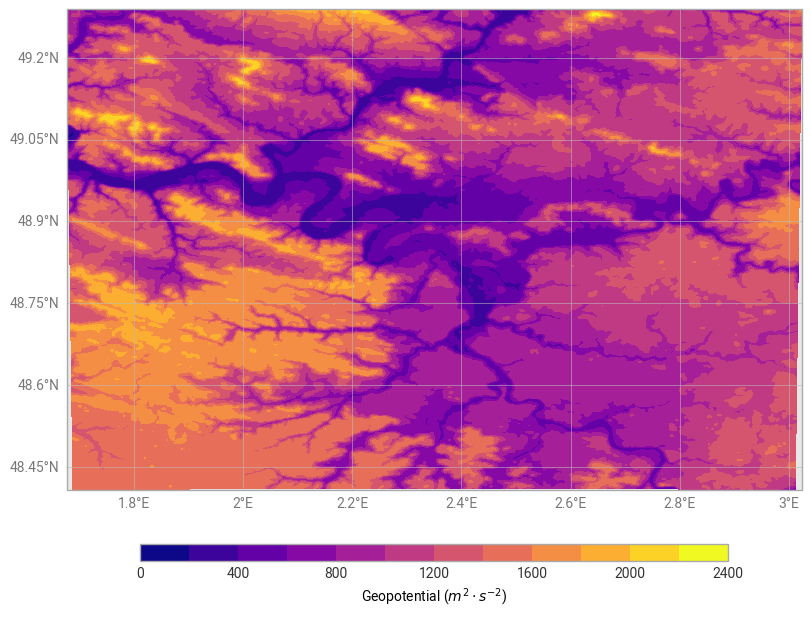

In [32]:
plot_map(data.sel({"shortName": "z", "level":90, "stepRange": "0s"}))

In [33]:
# Convert to xarray
atm = data.sel({"typeOfLevel": "hybrid"}).to_xarray()
atm["step"] = data.sel({"typeOfLevel": "hybrid"}).datetime()["valid_time"]

In [34]:
# Extract a single point and scale z
x0 = 250
y0 = 250
new = atm[PARAM].isel(x=x0,y=y0)
new["z"] = (atm["z"].isel(x=x0,y=y0) / 9.81)

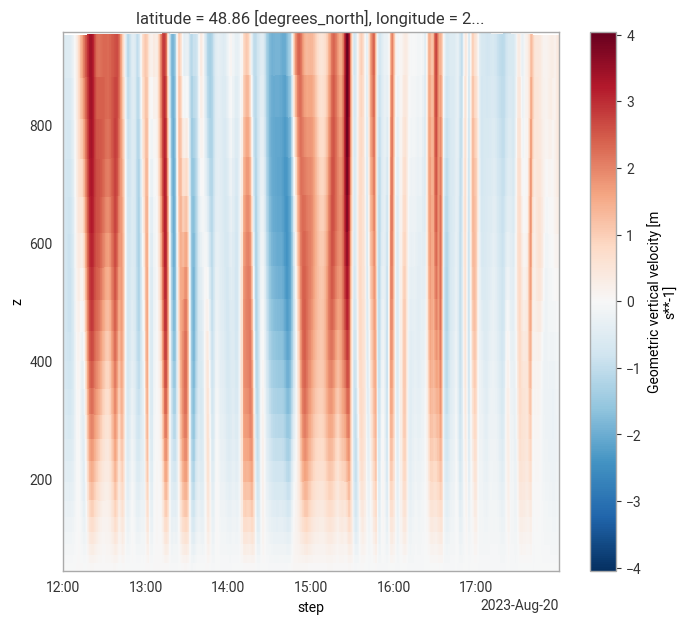

In [35]:
# Time to plot!
new.plot.pcolormesh(x="step",y="z")